# 🎙️ L5: Text-to-Speech (TTS)

---

Welcome to the second lab (L5) about **speech synthesis (aka TTS)**! We will get familiarised to how **end-to-end synthesis** works, and how we automatically evaluate it.

To do so, we are going to illustrate it with an **open-source model called XTTS**, which is based on one of the latest trends in **generative AI**: modelling speech the same way **big LLMs (ChatGPT, Claude...)** model text!

We will:
- 1) **Build the synthesis pipeline** of XTTS step by step.
- 2) Create functions to **evaluate two quality aspects of our synthesis** - intelligibility (using an ASR) and speaker similarity to reference (using a speaker encoder)
- 3) Imagine that we are given the task of building a new voice - we will **do speaker generation** and evaluate its outcomes.
- 4) **Play with the TTS** we built... and even try to clone our own voice!

⚠️ - Make sure to connect your runtime to a GPU for faster inference! Still, you should be able to run the notebook with CPU, if you have issues with GPU.

## 📦 Imports

First, we will use **pip** to install [**coqui-tts**](https://github.com/coqui-ai/TTS), an open-source library that contains many TTS models. Particularly, we use it because it has the implementation and weights of [XTTS](https://docs.coqui.ai/en/latest/models/xtts.html#). Additionally, we set up a particular version of numpy that works with Coqui, and jiwer, to compute WER scores later on.

(!) If you find this issue, click on **Restart session** and re-run this cell.
```
WARNING: The following packages were previously imported in this runtime:
  [numpy]
```

In [ ]:
!sudo apt-get install -q -y timidity libsndfile1
# Fix June 2025
#!pip install pydub numba music21 librosa jiwer numpy==1.26.4 coqui-tts==0.24.2 torch==2.1.0
# Fix October 2025
!pip install pydub numba music21 librosa jiwer numpy==1.26.4 coqui-tts

Reading package lists...
Building dependency tree...
Reading state information...
libsndfile1 is already the newest version (1.0.31-2ubuntu0.2).
timidity is already the newest version (2.14.0-8ubuntu1.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [ ]:
# Math, tensor and audio backend libs
import numpy as np
import torch
import torchaudio

# Word error rate libs
from jiwer import wer

# Plotting libs
import librosa.display
import matplotlib.pyplot as plt
import IPython
from sklearn.manifold import TSNE

# Audio imports
import librosa
from base64 import b64decode
from IPython.display import Audio, Javascript
from pydub import AudioSegment
from scipy.io import wavfile

# Coqui text-to-speech lib
from TTS.api import TTS

## 🤖 TTS Model

Let's download XTTS v2 and store it into a Python object. Such object contains all the code, modules and model neurons (weights) to run synthesis

In [ ]:
# Keep this to True if you're using a GPU instance (recommended), otherwise set to False.
# If GPU is set, the TTS model will be loaded in the GPU to speed up computation.
GPU = True

# Sampling rate definitions. In ASR, 16000 Hz is the typical sampling rate.
# However, in TTS we normally operate at 24000 Hz, to give extra resolution.
ASR_SAMPLING_RATE = 16000
TTS_SAMPLING_RATE = 24000

# Get the XTTS model. Remember to accept the license by typing "y" when it is prompted.
tts = TTS("tts_models/multilingual/multi-dataset/xtts_v2", gpu=GPU)

/usr/local/lib/python3.12/dist-packages/TTS/api.py:93: UserWarning: `gpu` will be deprecated. Please use `tts.to(device)` instead.
  warnings.warn("`gpu` will be deprecated. Please use `tts.to(device)` instead.")


## ⚙️ XTTS Modules
There is a single line function that you can use to synthesize text with XTTS... but if we simply use that, we won't learn so much, right? ;)

Let's instead, build the synthesis pipeline ourselves! We're going to get every different part of the XTTS engine, and see how it operates. Being so, let's store in different Python instance every module of XTTS:
- 📃 **Text Tokenizer** - it translates text strings into integer text tokens
- 📃 **Text Embedder** - it encodes text tokens into higher dimensional text embeddings
- 👤 **Speaker Encoder & Embeddings** - a neural module that captures the characteristics of a speaker into embeddings, so we can tell the model which identity to recreate
- 👄 **Speech Generate-Pretraining Transformer (GPT)** - the main component of XTTS, it uses text and speaker embeddings to generate speech tokens and latents.
- 🔉 **HiFi-GAN Decoder** - a module that acts as a vocoder: it converts speech latents into a waveform you can listen to.

In [ ]:
# Text tokenizer and embedder
tokenizer = tts.synthesizer.tts_model.tokenizer
text_embedder = tts.synthesizer.tts_model.gpt.text_embedding

# Speaker encoder
speaker_encoder = tts.synthesizer.tts_model.hifigan_decoder.speaker_encoder
speakers_dict = tts.synthesizer.tts_model.speaker_manager.speakers # <- this contains speaker names and their speaker embeddings

# Speech GPT
gpt = tts.synthesizer.tts_model.gpt

# Vocoder - a HiFi-GAN decoder
hifigan_decoder = tts.synthesizer.tts_model.hifigan_decoder

## 🪢 Synthesis Pipeline

Now, let's build the synthesis pipeline, extracting the required inputs and passing them through each XTTS module. Remember that the pipeline looks like this:

1) text -> **(tokenizer)** -> tokens -> **(embedder)** -> text embeddings

2) text embeddings + GPT speaker conditioning latents -> **(GPT)** -> speech tokens -> **(GPT)** -> speech latents

3) speech latents + speaker embeddings -> **(HiFi-GAN)** -> waveform

⚠️ - Due to certain design choices, both GPT and HiFi-GAN use different types of speaker embeddings. That's why we have "GPT speaker conditioning latents" (for GPT) and "speaker embeddings" (for HiFi-GAN).

⚠️ - Coqui TTS gives GPT and HiFi-GAN speaker embeddings that are already precomputed, so you can choose a particular voice from their voice bank. We will see later how to compute new speaker embeddings from new voices.

### 📃 Embedding text

As speech synthesis is called also "text-to-speech", it is natural to think that text is the essential input to a TTS model. Text is input as a string, but as neural networks operate with numbers, we need to convert the our string to a sequence of integer tokens. This is the step we call **tokenization**. Let's use the **tokenizer** module to do it.

In [ ]:
text = "Hi! I love text to speech synthesis." # <- the input text to be synthesised
language = "en" # <- XTTS needs the language code to be prompted, so it knows which language it has to speak. This will be put in the text token sequence

In [ ]:
def tokenize_text(text, language, tokenizer):
    # Normalize text to lower-case
    text = text.strip().lower()

    # Get integer tokens with the tokenizer
    text_tokens = tokenizer.encode(text, language)

    return text_tokens

✍️ **TASK 1** - Tokenize the input text.

In [ ]:
text_tokens = tokenize_text(text, language,tokenizer)

print(f"Text tokens = {text_tokens}")
print(f"Token object type = {type(text_tokens)}")
print(f"Length of the token sequence = {len(text_tokens)}")

Text tokens = [259, 1173, 3, 2, 22, 2, 99, 76, 2, 33, 169, 33, 2, 51, 2, 1523, 1763, 21, 2, 2427, 27, 42, 32, 54, 9]
Token object type = <class 'list'>
Length of the token sequence = 25


✍️ **TASK 2** - Now you got the token sequence, but remember we're operating with a neural TTS model in PyTorch... This means that you need to convert your text tokens sequence to a PyTorch tensor.

Look how you convert a list of integers into a tensor of integers in the PyTorch documentation. Once you've done it, manipulate its shape, so it has (batch_size = 1, text_sequence_length). For example, if your list of tokens has 25 tokens, your integer token tensor should have shape (1, 25).

In [ ]:
def tokenize_text_to_tensor(text, language, tokenizer, gpu=True):
    # Normalize text to lower-case
    text = text.strip().lower()

    # Get integer tokens with the tokenizer
    text_tokens = tokenizer.encode(text, language)

    # Implement here the list to integer tensor conversion
    text_tokens = torch.tensor(text_tokens)
    print(text_tokens.shape)
    # Adjust the shape of the tensor so it is (1, text_sequence_length)
    text_tokens = text_tokens.unsqueeze(0) #añadir una dimension
    print(text_tokens.shape)

    if gpu:
        text_tokens = text_tokens.cuda()

    return text_tokens

# Implement the call to convert your text to tensors
text_tokens = tokenize_text_to_tensor(text, language, tokenizer)

assert torch.is_tensor(text_tokens), f"Error! text_tokens is not a torch tensor, is: {type(text_tokens)}."
assert text_tokens.shape == (1, len(tokenizer.encode(text, language))), f"Error! The text tokens shape detected is: {text_tokens.shape}"
assert not torch.is_floating_point(text_tokens), f"Error! The tensor is not integer type, it is: {text_tokens.dtype}"

print(f"Text tokens tensor = {text_tokens}")
print(f"Text tokens type = {text_tokens.dtype}")
print(f"Text tokens shape = {text_tokens.shape}")

torch.Size([25])
torch.Size([1, 25])
Text tokens tensor = tensor([[ 259, 1173,    3,    2,   22,    2,   99,   76,    2,   33,  169,   33,
            2,   51,    2, 1523, 1763,   21,    2, 2427,   27,   42,   32,   54,
            9]], device='cuda:0')
Text tokens type = torch.int64
Text tokens shape = torch.Size([1, 25])


In [ ]:
# You can take a look at how the tokenizer looks from the inside. Let's get the HuggingFace Tokenizer object.
huggingface_tokenizer = tokenizer.tokenizer

vocab_size = huggingface_tokenizer.get_vocab_size()
vocab = huggingface_tokenizer.get_vocab()

print(f"Tokenizer vocabulary size = {vocab_size}")
print(f"Tokenizer vocabulary = {vocab}")

#  See more here "https://huggingface.co/docs/tokenizers/api/tokenizer".

Tokenizer vocabulary size = 6681
Tokenizer vocabulary = {'inn': 691, 'během': 3351, 'لو': 4399, 'pani': 2517, 'rzu': 2546, 'erst': 606, 'सो': 6449, 'en4': 4606, 'mü': 516, 'myeo': 5992, 'челове': 3753, 'हु': 6312, 'meru': 5256, 'několi': 3206, 'ты': 3533, 'ely': 5465, 'не': 3419, 'kul': 2518, 'aar': 2740, 'सी': 6316, 'uje': 3148, 'ihren': 667, 'det': 682, 'trás': 1946, 'geu': 5828, 'ii': 5079, 'ə': 1471, 'अपने': 6369, 'loro': 1548, 'مٌ': 4410, 'őr': 5558, 'mar': 681, 'zemí': 3291, 'día': 1206, 'pá': 3183, 'saki': 5337, 'أم': 4258, 'J': 5769, 'ны': 3427, 'ggen': 2956, 'xing1': 4858, 'хот': 3631, 'تق': 4319, 'prec': 1825, 'iss': 5824, 'يَا': 4238, 'ओं': 6423, 'آ': 3942, 'उनकी': 6656, 'че': 3708, 'ol': 392, 'dere': 1529, 'eln': 668, 'صل': 4267, 'tachiba': 5251, 'други': 3936, 'olu': 2200, 'их': 3633, 'wieder': 457, 'eneun': 5939, 'ébe': 5708, 'inda': 1805, 'вер': 3500, 'ně': 3042, 'ente': 1122, 'ضا': 4444, 'дей': 3607, 'дар': 3565, 'salang': 6009, 'أع': 4189, 'bu4': 4594, 'dakara': 5411, 

You should see that the vocabulary contains common word pieces from many different languages. That is because it is a Byte-Pair Encoder (BPE) tokenizer, more info [here](https://huggingface.co/learn/nlp-course/chapter6/5).

Now, you can actually revert your tokenization operation. Run the following cell to send your text tokens back into strings.

In [ ]:
# Do the reverse operation
text_from_token_list = []
for token in text_tokens[0, :]:
    text_from_token = huggingface_tokenizer.id_to_token(token)
    text_from_token_list.append(text_from_token)

# It is not exactly what you wrote in the beginning, you see some strings are substituted by others.
# Like whitespace " " is codified as "[SPACE]". Don't worry about it, this is all internal logic from the library, but you can witness overall how a tokenizer works.
# Also noticed how, as mentioned before, the language code has been prepended to the text sequence internally by the tokenizer.
print(text_from_token_list)

['[en]', 'hi', '!', '[SPACE]', 'i', '[SPACE]', 'lo', 've', '[SPACE]', 't', 'ex', 't', '[SPACE]', 'to', '[SPACE]', 'spe', 'ec', 'h', '[SPACE]', 'sy', 'n', 'the', 's', 'is', '.']


✍️ **TASK 3** - As you see, an integer token is a shallow codification of text, with little information. It is useful to expand these tokens to larger embeddings, which codify more information relevant to our synthesis task.

Use the **text_embedder** module to convert tokens into embeddings. Simply forward the **text_tokens** through **text_embedder** and examine these.

In [ ]:
# Implemented here the forward call of text_tokens through text_embeddings
text_embeddings = text_embedder(text_tokens)

assert text_embeddings.shape == (1, text_tokens.shape[1], 1024)

# And visualize. Expected shape is (batch_size, text_sequence_length, dimension).
# You see? The length is the same as in the token sequence, but now every token has been expanded to a large embedding of 1024.
# This enriches the text knowledge of our model.
print(f"Text tokens shape = {text_tokens.shape}")
print(f"Text embeddings shape = {text_embeddings.shape}")

Text tokens shape = torch.Size([1, 25])
Text embeddings shape = torch.Size([1, 25, 1024])


### 📃 Getting speaker embeddings

Of course, you may input text alone to a TTS but... which kind of voice identity should it output? That is why another essential input for a TTS is an encoding of the speaker identity to replicate.

XTTS has two encoders that codify two types of speaker embeddings. One is used to condition GPT, and the other to condition HiFi-GAN. GPT is supposed to output the highest level details of speaker identity, prosody and style. HiFi-GAN is supposed to then add on top fine-level details that yield a nice sounding waveform.

As mentioned before, XTTS library has some precomputed GPT and HiFi-GAN speaker embeddings that we can inspect and feed to the model to get different output identities.

In [ ]:
# We can get the speaker names to use from the speakers dict that we extracted before
speaker_names = speakers_dict.keys()
print(speaker_names)

dict_keys(['Claribel Dervla', 'Daisy Studious', 'Gracie Wise', 'Tammie Ema', 'Alison Dietlinde', 'Ana Florence', 'Annmarie Nele', 'Asya Anara', 'Brenda Stern', 'Gitta Nikolina', 'Henriette Usha', 'Sofia Hellen', 'Tammy Grit', 'Tanja Adelina', 'Vjollca Johnnie', 'Andrew Chipper', 'Badr Odhiambo', 'Dionisio Schuyler', 'Royston Min', 'Viktor Eka', 'Abrahan Mack', 'Adde Michal', 'Baldur Sanjin', 'Craig Gutsy', 'Damien Black', 'Gilberto Mathias', 'Ilkin Urbano', 'Kazuhiko Atallah', 'Ludvig Milivoj', 'Suad Qasim', 'Torcull Diarmuid', 'Viktor Menelaos', 'Zacharie Aimilios', 'Nova Hogarth', 'Maja Ruoho', 'Uta Obando', 'Lidiya Szekeres', 'Chandra MacFarland', 'Szofi Granger', 'Camilla Holmström', 'Lilya Stainthorpe', 'Zofija Kendrick', 'Narelle Moon', 'Barbora MacLean', 'Alexandra Hisakawa', 'Alma María', 'Rosemary Okafor', 'Ige Behringer', 'Filip Traverse', 'Damjan Chapman', 'Wulf Carlevaro', 'Aaron Dreschner', 'Kumar Dahl', 'Eugenio Mataracı', 'Ferran Simen', 'Xavier Hayasaka', 'Luis Moray', 

In [ ]:
# And we may use the name of the first speaker, for example, to extract the GPT and HiFi-GAN speaker embeddings
gpt_speaker_emb, hifigan_speaker_emb = speakers_dict['Kumar Dahl'].values()
print(f"GPT speaker embedding shape = {gpt_speaker_emb.shape}")
print(f"HiFi-GAN speaker embedding shape = {hifigan_speaker_emb.shape}")

GPT speaker embedding shape = torch.Size([1, 32, 1024])
HiFi-GAN speaker embedding shape = torch.Size([1, 512, 1])


HiFi-GAN speaker embedding consists of a single embedding of size 512.
However, GPT's consists of 32 embeddings of size 1024.

This is a bit more advanced information, but if you're curious about it... GPT uses more and bigger speaker embeddings to inpose stronger conditioning, not only to recreate the speaker identity, but also to try to capture their style, accent, emotion... Whereas HiFi-GAN uses a smaller embedding that is supposed to only add some details of the speaker identity. GPT cooks the cake, and HiFi-GAN adds the cherry on top, if you want to think it that way.

✍️ **TASK 4** - Let's make a plot of the speaker clusters, according to the traits defined in their speaker embeddings. We will use t-SNE to visualize that. Don't worry about the specifics of t-SNE for now, consider it as an algorithm that allows you to downsample a large embedding into a few dimensions that you can plot to visualize your data distribution.

We give the function to plot t-SNE here below.

In [ ]:
%matplotlib inline

def plot_tsne(embeddings, labels=None, perplexity=30, n_iter=1000):
    # Convert to numpy if it's a PyTorch tensor
    if isinstance(embeddings, torch.Tensor):
        embeddings = embeddings.cpu().detach().numpy()

    # Perform t-SNE on the embeddings
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Create a scatter plot
    plt.figure(figsize=(10, 8))

    if labels is not None:
        # If labels are provided, color the points based on labels
        unique_labels = np.unique(labels)
        for label in unique_labels:
            indices = np.where(labels == label)
            plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=f"Speaker {label}")
        plt.legend()
    else:
        # If no labels, plot all points with the same color
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

    plt.title("t-SNE of Speaker Embeddings")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid(True)
    plt.show()

In [ ]:
# Now, your task is to collect all the HiFi-GAN speaker embeddings from the speakers dict into a list.
hifigan_speaker_embeddings_list = []
for speaker_name in speaker_names:
    # Extract here the HiFi-GAN speaker embedding and store it in the list above
    gpt_speaker_emb, hifigan_speaker_emb = speakers_dict[speaker_name].values()
    # Remember that the shape of each embedding is (1, 512, 1), right?
    # Modify the shape of the embeddings tensor so it is (512).
    hifigan_speaker_emb = hifigan_speaker_emb.squeeze()
    hifigan_speaker_embeddings_list.append(hifigan_speaker_emb)

In [ ]:
# We may now convert the list of speaker embeddings into a tensor of shape
# (number_of_speaker_embeddings, speaker_embedding_dimension)
hifigan_speaker_embeddings = torch.stack(hifigan_speaker_embeddings_list)

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


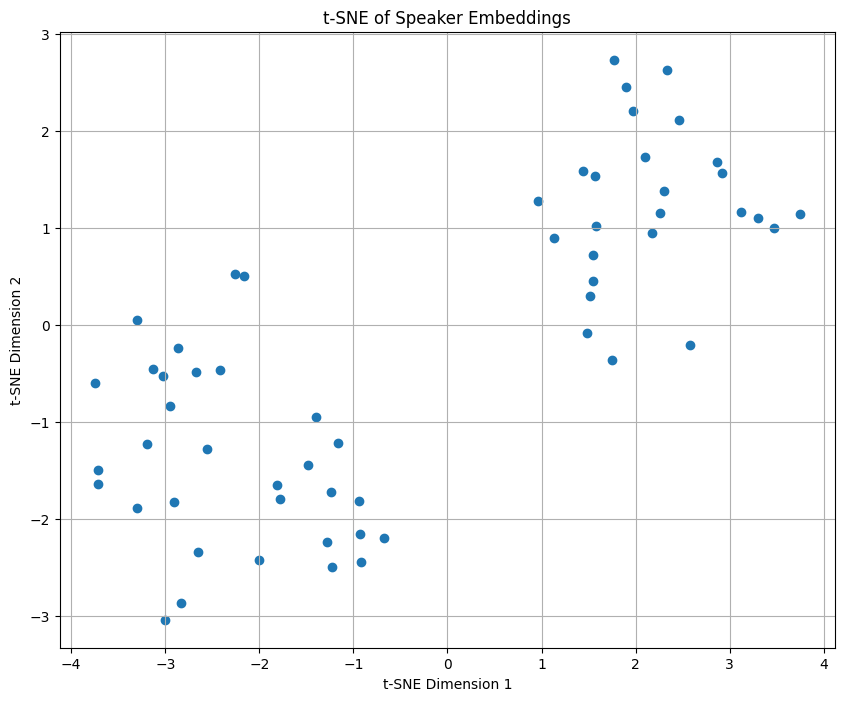

In [ ]:
# And finally, plot the t-SNE. You should notice two clusters, why do you think
# there are two main clusters of speaker voices?
plot_tsne(hifigan_speaker_embeddings)

### 👄 Running the GPT

We have our text tokens and GPT speaker embeddings ready. That means we can now generate speech tokens and latents/embeddings with the speech GPT.

In [ ]:
# Decoding arguments. These condition the characteristics of the output.
top_p = 0.8 # <- Lower values mean the decoder produces more “likely” (aka boring) outputs
temperature = 0.65 # <- The softmax temperature of the autoregressive model. Lower means more boring, higher might yield more expressive (but more prone to hallucination) speech

In [ ]:
# Run this to make sure that GPT and HiFi-GAN speaker embeddings are moved to the GPU if that's available
if GPU:
    gpt_speaker_emb = gpt_speaker_emb.cuda()
    hifigan_speaker_emb = hifigan_speaker_emb.cuda()

✍️ **TASK 5** - Pass the text tokens and the GPT speaker embeddings to the **generate** call of the **gpt** module. Because this is an autoregressive module, it will generate tokens until it predicts the "end of sentence" token, so every run might yield different output length.

In [ ]:
with torch.no_grad():
    speech_tokens = gpt.generate(
        cond_latents=gpt_speaker_emb, # <- pass here the GPT speaker embeddings
        text_inputs=text_tokens, # <- pass here the text tokens (not the embeddings, gpt.generate automatically will get these from the tokens)
        input_tokens=None,
        do_sample=True,
        top_p=top_p,
        temperature=temperature,
        output_attentions=False,
    )

# Visualize speech GPT tokens...
print(f"Predicted speech tokens = {speech_tokens}")
print(f"Predicted speech tokens shape = {speech_tokens.shape}")

Predicted speech tokens = tensor([[ 293,    7,   50,   12,  371,  371,  119,  181,  298,  926,  799,  216,
          531,  216,  732,  732,  473,  418,  971,  582,  971,   10,   50,   37,
           65,  389,  158,  323,  323,  619,  751,  345,  693,  454,  313,  389,
          294,  831,  537,  101,  492,    4,  165,   32,   32,  838,  856,   37,
          165,   65,  446,  570,  218,  810,  800,   37,   37,  363,  849,  643,
          192,  403,  886,  810,  700,  880,  228,  790,  825,  825,  987, 1006,
         1012, 1025]], device='cuda:0')
Predicted speech tokens shape = torch.Size([1, 74])


Speech tokens look actually like text tokens, right? That is the idea between these large GPTs to speech, which is to operate with speech tokens the same way
we normally operate with text.

However, as we discussed, tokens are semantically rich, but are really low dimensional. Once we've synthesised speech tokens, we want to upsample them to a high dimensional representation that we can listen to.

We could try to vocode directly speech tokens into a waveform... But research
has shown that it is possible to first convert speech tokens into high dimensional speech latents/embeddings, using GPT itself. Let's forward the extracted speech tokens to GPT to get the last layer embeddings. We shall vocode these afterwards.

In [ ]:
# GPT needs to know explicitly which are the expected speech and text tokens
# lengths to return the latents.
expected_output_len = torch.tensor(
    [speech_tokens.shape[-1] * gpt.code_stride_len], device=text_tokens.device
)
text_len = torch.tensor([text_tokens.shape[-1]], device=text_tokens.device)

# This is the forward pass of GPT, setting "return_latent" to True,
# so it returns the last layer embeddings instead of yielding
# the speech tokens prediction.
with torch.no_grad():
    speech_latents = gpt(
        text_tokens,
        text_len,
        speech_tokens,
        expected_output_len,
        cond_latents=gpt_speaker_emb,
        return_attentions=False,
        return_latent=True,
    )

# Let's get GPT latents corresponding to the GPT codes.
# Like before, when we got high dimensional embeddings from text, we get high dimensional embeddings from speech GPT codes.
# Thus, we get more information about each token in the context of the others, that we will use to upsample speech GPT codes to the waveform domain.
print(f"Speech tokens shape = {speech_tokens.shape}")
print(f"Speech latents/embeddings shape = {speech_latents.shape}")

Speech tokens shape = torch.Size([1, 74])
Speech latents/embeddings shape = torch.Size([1, 74, 1024])


✍️ **TASK 6** - Now that you have the synthesised speech latents, it is time to use HiFi-GAN vocoder to obtain the final waveform, so we can listen to it. Code the forward pass of the **hifigan_decoder** and get the waveform.

In [ ]:
hifigan_speaker_emb.unsqueeze(0).unsqueeze(-1).shape

torch.Size([1, 512, 1])

Predicted waveform shape = torch.Size([82432])


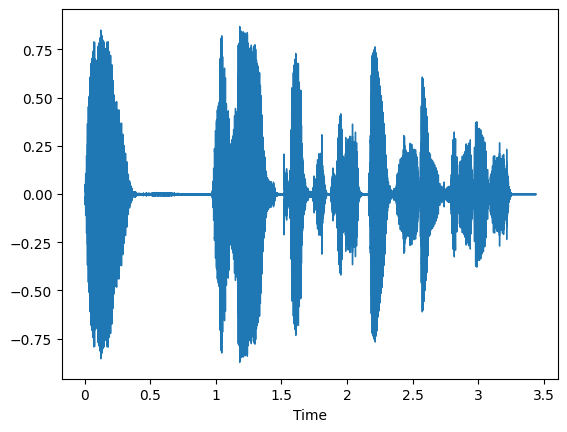

In [ ]:
with torch.no_grad():
    pred_wav = hifigan_decoder(
        speech_latents, # <- pass here the speech latents
        g=hifigan_speaker_emb.unsqueeze(0).unsqueeze(-1) # <- pass here the HiFi-GAN speaker embedding. Remember to put it into a shape of (1, 512, 1)
    ).cpu().squeeze()

print(f"Predicted waveform shape = {pred_wav.shape}")
librosa.display.waveshow(pred_wav.numpy(), sr=TTS_SAMPLING_RATE)
IPython.display.Audio(pred_wav.numpy(), rate=TTS_SAMPLING_RATE)

## ❓ Evaluating Synthesis

Evaluating any generation task with AI is hard, because there is not a single metric that covers how good the output is. In TTS research, we normally have two proxy metrics to see if our generation is doing good:
- We can check if the synthesis is intelligible and correct, by transcribing the output with an ASR and computing the WER.
- We can check if the synthesised speaker identity is good, by getting the speaker embedding of the synthesised output, and comparing it against the speaker embedding used for synthesis.

✍️ **TASK 7** - Use what you learned about ASR in the last session. Implement an ASR call to transcribe **pred_wav** into text, and check what is the WER by comparing the synthesised text with the original ground truth text.

In [ ]:
# I'm suggesting to use Whisper (small) for this, but feel free to try any other ASR.
from transformers import WhisperProcessor, WhisperForConditionalGeneration
asr_processor = WhisperProcessor.from_pretrained("openai/whisper-small")
asr = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")
asr.config.forced_decoder_ids = None

In [ ]:
# If you're using Whisper, check the documentation to do the correct calls
# for transcribing with it.
# See https://huggingface.co/openai/whisper-small#english-to-english

def transcribe_speech(pred_wav, sampling_rate):
    # Mind that the required sampling rate for ASR is 16000!
    input_features = asr_processor.feature_extractor(pred_wav, sampling_rate=sampling_rate,return_tensors="pt").input_features
    # generate token ids
    predicted_ids = asr.generate(input_features)
    print(predicted_ids)
    # decode token ids to text
    pred_text = asr_processor.batch_decode(predicted_ids)


    return pred_text

pred_text = transcribe_speech(pred_wav, sampling_rate=ASR_SAMPLING_RATE)

tensor([[  286,   959,  2487,   281,  6218, 30252,    13]])


In [ ]:
# Because our ground truth text and synthesised text might have punctuations, let's
# remove them and normalize the text.
pred_text_norm = asr_processor.tokenizer._normalize(pred_text[0])
ground_truth_text_norm = asr_processor.tokenizer._normalize(text)

print(f"Ground truth text = {text}")
print(f"Ground truth text (normalised) = {ground_truth_text_norm}")
print(f"Pred text = {pred_text}")
print(f"Pred text (normalised) = {pred_text_norm}")

Ground truth text = Hi! I love text to speech synthesis.
Ground truth text (normalised) = hi i love text to speech synthesis
Pred text = [' I love text to speech synthesis.']
Pred text (normalised) = i love text to speech synthesis


/usr/local/lib/python3.12/dist-packages/transformers/models/whisper/tokenization_whisper_fast.py:406: UserWarning: The private method `_normalize` is deprecated and will be removed in v5 of Transformers.You can normalize an input string using the Whisper English normalizer using the `normalize` method.
  warnings.warn(


In [ ]:
# Let's compute the WER!
word_error_rate = wer(ground_truth_text_norm, pred_text_norm) * 100.0
print(f"WER of our synthesis = {word_error_rate}%")

WER of our synthesis = 14.285714285714285%


Finally, let's compute speaker similarity. We already have the HiFi-GAN speaker embedding of the original speaker. Now, let's use the HiFi-GAN speaker encoder to get the speaker embedding of the synthesised waveform.

In [ ]:
# The speaker encoder operates with 16000 Hz waveforms, so let's resample
# the predicted waveform to 16000 Hz.
pred_wav_16k = torchaudio.functional.resample(pred_wav, TTS_SAMPLING_RATE, ASR_SAMPLING_RATE)

# Let's get the speaker embedding of the synthesised audio.
synth_speaker_emb = speaker_encoder.forward(pred_wav_16k.unsqueeze(0).to(text_tokens.device), l2_norm=True).unsqueeze(-1).to(text_tokens.device).view(512)

print(f"Speaker embedding shape of the original speaker = {hifigan_speaker_emb.shape}")
print(f"Speaker embedding shape of the synthesised speaker = {synth_speaker_emb.shape}")

Speaker embedding shape of the original speaker = torch.Size([512])
Speaker embedding shape of the synthesised speaker = torch.Size([512])


✍️ **TASK 8** - Now, use cosine similarity to compare how close the original and synthesised speaker embeddings are. See the documentation here https://pytorch.org/docs/stable/generated/torch.nn.functional.cosine_similarity.html

In [ ]:
speaker_sim = torch.nn.functional.cosine_similarity(hifigan_speaker_emb.unsqueeze(0), synth_speaker_emb.unsqueeze(0)).squeeze()
print(f"Speaker cosine similarity = {speaker_sim * 100}%")

Speaker cosine similarity = 66.06670379638672%


## Speaker Generation

Until now, we've played with precomputed voices. But could you create a new voice? This is an exciting and ongoing research field.

I encourage you to think on new ways to create new voices. You could mix one or more speaker embeddings of different speakers, for instance... but how? That's up to you!

As we have limited time in this class, let's start with something simple. Let's simply get the HiFi-GAN speaker embedding from another speaker, and let's sum it to our current speaker embedding with a weighted sum.

In [ ]:
# Our utility function to linearly combine a speaker embedding with another.
def add_embedding_to_embedding_with_scale(speaker_emb_a, speaker_emb_b, scale):
    return speaker_emb_a + (speaker_emb_b * scale)

In [ ]:
# Let's generate a noise vector of the same shape of our HiFi-GAN embedding
_, hifigan_speaker_emb_b = speakers_dict["Daisy Studious"].values()
hifigan_speaker_emb_b = hifigan_speaker_emb_b.view(512)

✍️ **TASK 9** - Manually modify the scale and check how does the output synthesis respond. Listen to the samples, and also keep track of the WER and speaker similarity values. What do you think about it?

Remember that the larger the scale is, the more you combine the new speaker embedding into the old one.

tensor([[  286,   959,  2487,   281,  6218, 30252,    13]])
Previous WER = 14.285714285714285%
New WER = 14.285714285714285%
Previous speaker cosine similarity = 66.06670379638672%
New speaker cosine similarity = 36.909873962402344%


/usr/local/lib/python3.12/dist-packages/transformers/models/whisper/tokenization_whisper_fast.py:406: UserWarning: The private method `_normalize` is deprecated and will be removed in v5 of Transformers.You can normalize an input string using the Whisper English normalizer using the `normalize` method.
  warnings.warn(


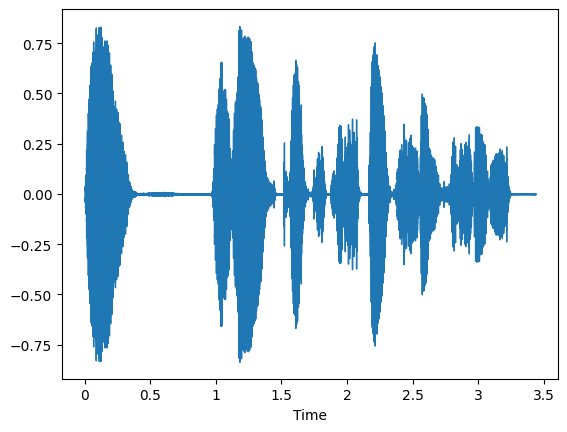

In [ ]:
scale = 1 #it's not linearly percievable
hifigan_speaker_emb = hifigan_speaker_emb.cuda()
hifigan_speaker_emb_b = hifigan_speaker_emb_b.cuda()


# Re-vocode with the new speaker identity
new_hifigan_speaker_emb = add_embedding_to_embedding_with_scale(hifigan_speaker_emb, hifigan_speaker_emb_b, scale)
with torch.no_grad():
    new_speaker_pred_wav = hifigan_decoder(speech_latents, g=new_hifigan_speaker_emb.unsqueeze(0).unsqueeze(-1)).cpu().squeeze()

# Compute WER
new_pred_text = transcribe_speech(new_speaker_pred_wav, sampling_rate=ASR_SAMPLING_RATE)
new_wer = wer(ground_truth_text_norm, asr_processor.tokenizer._normalize(new_pred_text[0]))
print(f"Previous WER = {word_error_rate}%")
print(f"New WER = {new_wer * 100}%")

# Compute speaker cosine similarity
new_pred_wav_16k = torchaudio.functional.resample(new_speaker_pred_wav, TTS_SAMPLING_RATE, ASR_SAMPLING_RATE)
new_synth_speaker_emb = speaker_encoder.forward(new_pred_wav_16k.unsqueeze(0).to(text_tokens.device), l2_norm=True).unsqueeze(-1).to(text_tokens.device).view(512)
new_speaker_sim = torch.nn.functional.cosine_similarity(new_synth_speaker_emb, hifigan_speaker_emb, dim=0)
print(f"Previous speaker cosine similarity = {speaker_sim * 100}%")
print(f"New speaker cosine similarity = {new_speaker_sim * 100}%")

# Visualize waveforms
librosa.display.waveshow(new_speaker_pred_wav.numpy(), sr=TTS_SAMPLING_RATE)
IPython.display.Audio(new_speaker_pred_wav.detach().numpy(), rate=TTS_SAMPLING_RATE)

# 🤩 Play time!

That's all the work for today. Now that you have a better picture on how XTTS works on the inside, let me give you the function so you can run the full synthesis pipeline with a single command from the API.

Feel free to play with different sentences, speakers and so on. I recommend you to try sentences that convey different emotions ("I'm so sad...", "I'm really angry!!", etc.) to see how well does the model render emotions depending on text.

In [ ]:
input_text = "Hello world!"
input_language = "en"
input_speaker = "Ana Florence"

tts.tts_to_file(
    text=input_text,
    file_path="output.wav",
    speaker=input_speaker,
    language=input_language
)
IPython.display.Audio('output.wav', rate=TTS_SAMPLING_RATE)

# 🗣️ Use your own voice!

By definition, most of the new TTS models based on large generative paradigms are able to clone a voices with a few seconds of a voice prompt.

You can record yourself and pass that recording so XTTS extracts your speaker embeddings for GPT and HiFi-GAN. What do you think about it?

⚠️ - With great power comes great responsability... Always use voice cloning for the good, and never, ever, clone someone's voice without consent.

In [ ]:
#@title [Run this] Definition of the JS code to record audio straight from the browser

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=5, out_name='recorded_audio.wav'):
  try:
    from google.colab import output
  except ImportError:
    print('No possible to import output from google.colab')
    return ''
  else:
    print('Recording')
    display(Javascript(RECORD))
    s = output.eval_js('record(%d)' % (sec*1000))
    fname = out_name
    print('Saving to', fname)
    b = b64decode(s.split(',')[1])
    with open(fname, 'wb') as f:
      f.write(b)
    return fname

In [ ]:
EXPECTED_SAMPLE_RATE = ASR_SAMPLING_RATE

def convert_audio_for_model(user_file, output_file='converted_audio_file.wav'):
  audio = AudioSegment.from_file(user_file)
  audio = audio.set_frame_rate(EXPECTED_SAMPLE_RATE).set_channels(1)
  audio.export(output_file, format="wav")
  return output_file

def record_utterance(file_name='my_recording_wav'):
    file_name = record(5, file_name)
    converted_audio_file = convert_audio_for_model(file_name)
    input_audio, sr = torchaudio.load(converted_audio_file)
    return input_audio

Run the cell below to record yourself, the recording will be automatically stopped at 5 seconds, approx.

In [ ]:
yourself_recording_path = "yourself.wav"
input_audio = record_utterance(yourself_recording_path)
print(input_audio.shape)

input_audio_24k = torchaudio.functional.resample(input_audio, ASR_SAMPLING_RATE, TTS_SAMPLING_RATE)
torchaudio.save(yourself_recording_path, input_audio_24k, TTS_SAMPLING_RATE)

librosa.display.waveshow(input_audio_24k.squeeze().numpy(), sr=TTS_SAMPLING_RATE)
Audio(input_audio_24k.squeeze().numpy(), rate=TTS_SAMPLING_RATE)

In [ ]:
input_text = "Hello world! This is my robot self... or is it just me?"
input_language = "en"
output_file_path = "output_yourself.wav"

tts.tts_to_file(
    text=input_text,
    file_path=output_file_path,
    speaker_wav=yourself_recording_path,
    language=input_language
)
IPython.display.Audio(output_file_path, rate=TTS_SAMPLING_RATE)